# Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import datetime

# Morris Results

In [2]:
age_groups = [
    '0 - 4 Years','05 - 17 Years','18 - 29 Years', 
    '30 - 39 Years', '40 - 49 Years', 
    '50 - 64 Years', '65 - 74 Years', '75+ Years'
]
age_ranges = {
    '0 - 4 Years':[0, 4], '05 - 17 Years':[5, 17], 
    '18 - 29 Years':[18, 29], '30 - 39 Years':[30, 39], 
    '40 - 49 Years':[40, 49], '50 - 64 Years':[50, 64], 
    '65 - 74 Years':[65, 74], '75+ Years':[75, 100]
}

## Read individual files

In [3]:
# Import data
ages = ['UNDER5', 'AGE517', 'AGE1829', 'AGE4049', 'AGE3039', 'AGE5064', 'AGE6574', 'AGE75PLUS']
morris = 'figures_morris'

df = []
for i in range(len(ages)):
    x = pd.read_csv('./results/' + ages[i] + '/' + morris + '/Morris.csv')
    df.append(x)
     
age_total = []
# Age 
for i in range(len(ages)):
    age_total.append(df[i][df[i].Feature == ages[i]])

## Plot

In [4]:
# Function for formatter
class OOMFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        mpl.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

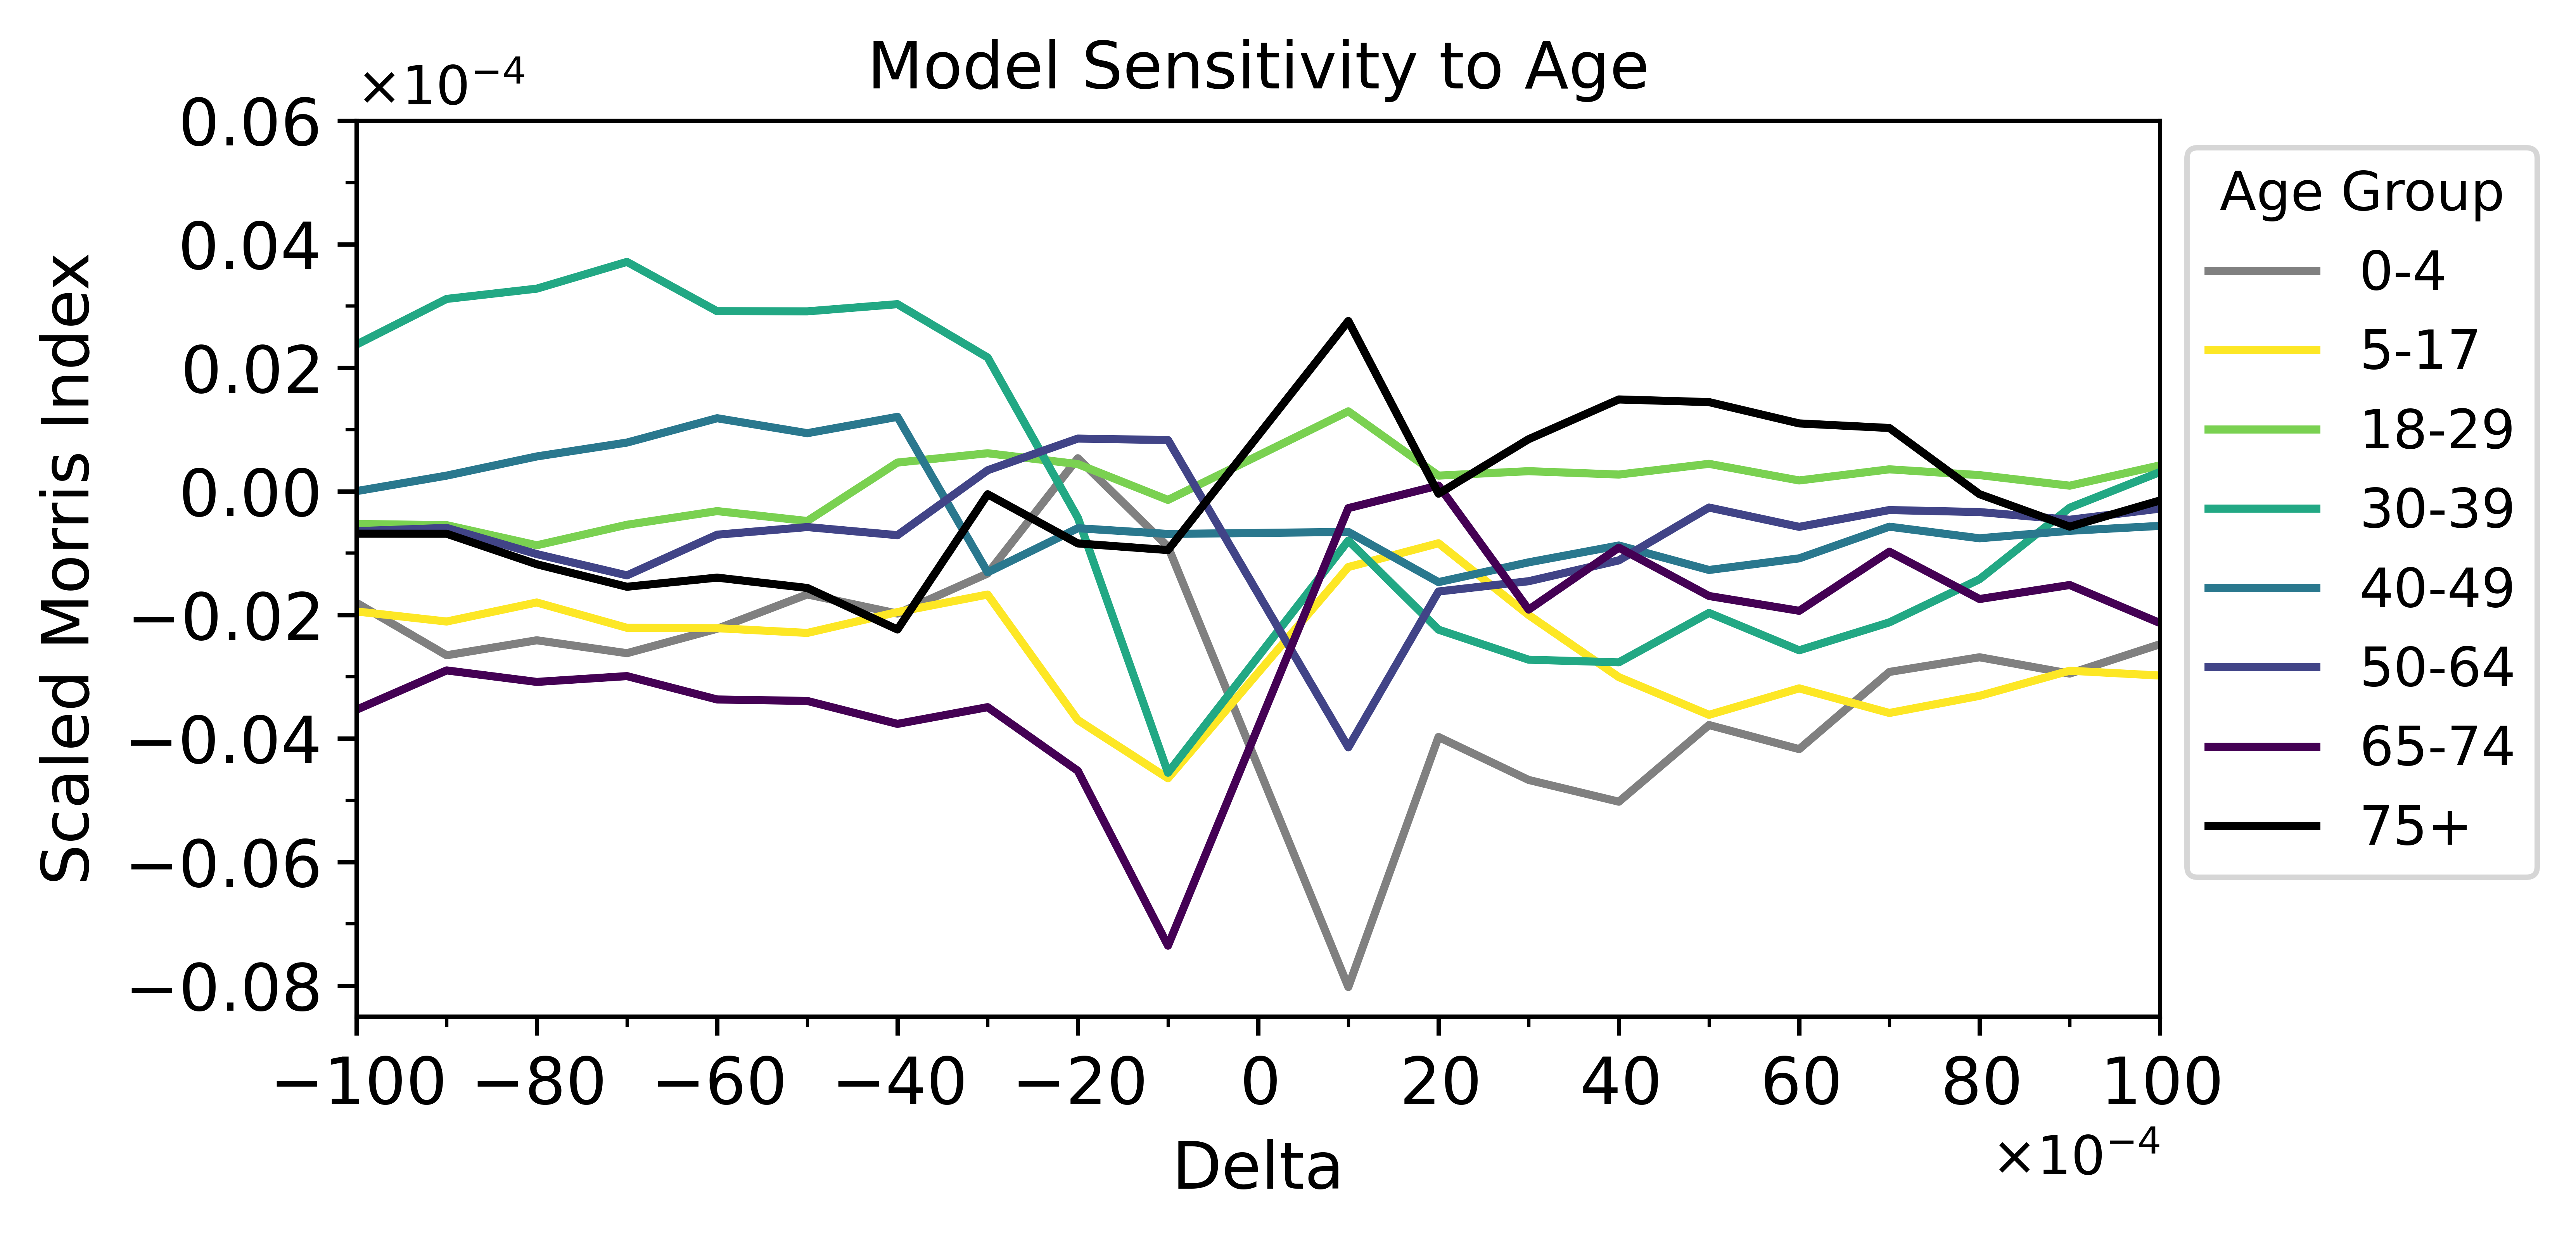

In [5]:
# Plot
mpl.rcParams['figure.dpi'] = 1000
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', sharey=True, figsize=(6, 3))
label = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']
color = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']

# plot the same data on both axes
for i in range(len(ages)):
    plt.plot(age_total[i].Delta, age_total[i].Morris_sensitivity, '-', linewidth=1.5, label=label[i], color=color[i])
    
# Scale axes
ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.2f"))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))   
ax.xaxis.set_major_formatter(OOMFormatter(-4, "%1.0f"))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
ax.xaxis.get_offset_text().set_visible(True)

# Format plot
ax.set_xticks([-0.01 , -0.008, -0.006, -0.004,
               -0.002, 0, 0.002, 0.004, 0.006,
               0.008, 0.01 ])
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(-0.085e-4, 0.06e-4)

# Minor ticks
ax.set_xticks([-90e-4, -70e-4, -50e-4, -30e-4, -10e-4, 10e-4, 30e-4, 50e-4, 70e-4, 90e-4], minor=True)
ax.set_yticks([-0.08e-4, -0.06e-4, -0.04e-4, -0.02e-4, 0, 0.02e-4, 0.04e-4, 0.06e-4], minor=False)
ax.set_yticks([-0.07e-4, -0.05e-4, -0.03e-4, -0.01e-4, 0, 0.01e-4, 0.03e-4, 0.05e-4], minor=True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add labels
plt.ylabel('Scaled Morris Index', size=12)
plt.xlabel('Delta', size=12)
plt.title('Model Sensitivity to Age', size=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Group')
plt.savefig('model sensitivity.png', bbox_inches='tight')
plt.show()

## Combine individual morris dataframes

In [6]:
# Get delta values
for i in range(0, len(ages)):
    df[i].Delta = round(df[i].Delta, 3)

deltas = list(df[0].Delta.unique())

In [7]:
ranking = pd.DataFrame()
ranking = ranking.reindex(index = age_groups)

for j in range(len(deltas)): 
    morris_values = []
    for i in range(0, len(ages)):
        x = df[i][(df[i]['Delta'] == deltas[j])
                & (df[i]['Feature'] != 'VaccinationFull')]['Morris_sensitivity']
        morris_values.append(x.values[0])

    ranking[str(deltas[j])] = morris_values

for i in ranking.columns: 
    ranking[i] = ranking[i].rank(ascending=True)

## Aggregated Morris result

In [8]:
result = pd.DataFrame()
result['mean_ranks'] = ranking.mean(axis = 1)
result['std_ranks'] = ranking.std(axis = 1)
result['median_ranks'] = ranking.median(axis = 1)
result = result.reset_index(names='Age Group')

# result[['mean_ranks', 'median_ranks']].apply(tuple,axis=1)\
#              .rank(method='dense',ascending=True).astype(int)
result

Age Group  mean_ranks  std_ranks  median_ranks
0    0 - 4 Years        2.25   1.517442           2.0
1  05 - 17 Years        2.40   0.994723           2.0
2  18 - 29 Years        6.80   0.767772           7.0
3  30 - 39 Years        5.50   2.460210           6.0
4  40 - 49 Years        5.60   1.231174           5.5
5  50 - 64 Years        5.30   1.380313           5.0
6  65 - 74 Years        2.65   1.926956           2.0
7      75+ Years        5.50   1.986799           5.0

In [9]:
result.rename({'mean_ranks':'Morris'}, inplace=True, axis=1)
result['Morris']  = result['Morris'].rank(ascending=False)
result[['Age Group', 'Morris']].style.background_gradient('Blues', subset=['Morris'])\
       .format({'Morris': '{:.2g}'})

# Ground Truth

## Cases by Age
https://data.cdc.gov/Public-Health-Surveillance/COVID-19-Weekly-Cases-and-Deaths-by-Age-Race-Ethni/hrdz-jaxc

### Preprocess

In [10]:
data = pd.read_csv('Ground Truth/COVID-19_Weekly_Cases_and_Deaths_by_Age__Race_Ethnicity__and_Sex.csv')

# Select all U.S. jurisdictions, age groups, sexes, races/ethnicities
data = data[data.jurisdiction == 'US']
data = data[data.age_group != 'Overall']
data = data[data.sex == 'Overall']
data = data[data.race_ethnicity_combined == 'Overall']
data.drop(columns=[
    'jurisdiction', 'sex', 'race_ethnicity_combined',
    'deaths', 'death_rate_per_100k', 'case_rate_per_100k'
], inplace=True)

data.rename(
    {'cases': 'Cases', 'age_group':'Age Group'}, 
    axis=1, inplace=True
) 

In [11]:
# Convert end_of_week column to DateTime
data['end_of_week'] = pd.to_datetime(data['end_of_week'])
data.rename({'age_group':'Age Group'}, axis=1, inplace=True)

data = data.sort_values(by=['end_of_week', 'Age Group'])
data = data.reset_index().drop(columns=['index'])

### Fix start date

In [12]:
# since it is cumulative weekly report, count started from 6 days early
first_date = data['end_of_week'].min() - pd.to_timedelta(6, unit='D')
start_df = pd.DataFrame({'Age Group':data['Age Group'].unique()})

start_df['end_of_week'] = first_date
start_df['Cases'] = 0
data = pd.concat([start_df, data])

In [13]:
# Select date range (end_of_week = 3/1/2020 to end_of_week = 12/27/2021)
start = max(pd.to_datetime('2020-03-01'), first_date)
end = pd.to_datetime('2021-11-27')
print(f'Whole data contains period {start} to {end}.')

data = data[(data['end_of_week']>=start) & (data['end_of_week']<=end)]

Whole data contains period 2020-03-01 00:00:00 to 2021-11-27 00:00:00.


### Combine age groups

In [14]:
# combine the second to fourth groups into a single one to  
# align with the county age distribution groups
age_5_17 = data[
    data['Age Group'].isin(
        ['end_of_week', '5 - 11 Years', '12 - 15 Years', '16 - 17 Years']
    )
].groupby('end_of_week').aggregate('sum', numeric_only=True).reset_index()
age_5_17['Age Group'] = '5 - 17 Years'

In [15]:
# drop the combined groups 
data = data[~data['Age Group'].isin(['5 - 11 Years', '12 - 15 Years', '16 - 17 Years'])]

data = pd.concat([data, age_5_17]).reset_index(drop=True)

In [16]:
# Address issue of age group order
data = data.replace('5 - 17 Years', '05 - 17 Years')

### Plot

In [17]:
from Class.PlotConfig import *

In [19]:
fig, ax = plt.subplots(figsize=(13, 8))
colors = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']
labels = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']

for index, (age_group, age_data) in enumerate(data.groupby('Age Group')):
    print(age_group)
    ax.plot(
        age_data['end_of_week'], age_data['Cases'], 
        color=colors[index], label=labels[index],
        linewidth=3.5 
        # marker=markers[index], markersize=8
    )

label_text = [] 
for loc in ax.get_yticks():
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/1e3:0.5g}K') 

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)
ax.set_ylim(0)

x_first_tick = data['end_of_week'].min()
x_last_tick = data['end_of_week'].max()
x_major_ticks = 5
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)

plt.ylabel(f'Weekly COVID-19 Cases', labelpad=15)
# plt.title('Weekly COVID-19 Cases by Age Group', size=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Groups')

plt.savefig('weekly_ground_truth.jpg', bbox_inches='tight', dpi=200)
# plt.show()

0 - 4 Years
05 - 17 Years
18 - 29 Years
30 - 39 Years
40 - 49 Years
50 - 64 Years
65 - 74 Years
75+ Years


### Aggregate

In [20]:
# Find sum of all cases for each age group during time period
data = data.groupby(by=["Age Group"]).sum('numeric_only').reindex(labels=age_groups).reset_index()

data

Age Group     Cases
0    0 - 4 Years   1249223
1  05 - 17 Years   6184296
2  18 - 29 Years  10018923
3  30 - 39 Years   7760789
4  40 - 49 Years   6767348
5  50 - 64 Years   8820765
6  65 - 74 Years   3289094
7      75+ Years   2505606

## Population by Age

These data are [estimates for April 1, 2020](https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html)


In [21]:
# Import data from csv
pop = pd.read_csv('Ground Truth/nc-est2021-agesex-res.csv', usecols=['SEX', 'AGE', 'ESTIMATESBASE2020'])
pop = pop[pop.SEX == 0]
pop = pop.rename(columns={'ESTIMATESBASE2020': 'population', 'AGE': 'age'})
pop = pop.drop(columns=['SEX'])

In [22]:
data["Population"] = 0

for age_group, age_range in age_ranges.items():
    total = pop[(age_range[0]<= pop['age']) & (pop['age']<=age_range[1])]['population'].sum(axis=0)
    data.loc[data['Age Group']==age_group, 'Population'] = total
    print(age_group, total)

0 - 4 Years 19392551
05 - 17 Years 54992661
18 - 29 Years 53013409
30 - 39 Years 45034182
40 - 49 Years 41003731
50 - 64 Years 63876118
65 - 74 Years 32346340
75+ Years 21790289


# Ground Truth Ranking

In [23]:
# Calculate percentage of age infected 
data["Infection Rate (%)"] = (data.Cases * 100.0 / data.Population).round(3)
data

Age Group     Cases  Population  Infection Rate (%)
0    0 - 4 Years   1249223    19392551               6.442
1  05 - 17 Years   6184296    54992661              11.246
2  18 - 29 Years  10018923    53013409              18.899
3  30 - 39 Years   7760789    45034182              17.233
4  40 - 49 Years   6767348    41003731              16.504
5  50 - 64 Years   8820765    63876118              13.809
6  65 - 74 Years   3289094    32346340              10.168
7      75+ Years   2505606    21790289              11.499

In [24]:
data.reset_index().style\
    .background_gradient('Blues', subset=['Infection Rate (%)'])\
    .format({'Cases': '{:,d}', 'Population': '{:,d}', 'Infection Rate (%)': '{:.1f}', 'Morris': '{:.0f}'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .set_properties(**{'text-align': 'center'})\
    .hide(axis='index')

In [25]:
# Add Morris ranking
data = data.merge(result[['Age Group', 'Morris']], on=['Age Group'], how='inner')

In [26]:
data.reset_index().style\
    .background_gradient('Blues', subset=['Infection Rate (%)', 'Morris'])\
    .format({'Cases': '{:,d}', 'Population': '{:,d}', 'Infection Rate (%)': '{:.1f}', 'Morris': '{:.0f}'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .set_properties(**{'text-align': 'center'})\
    .hide(axis='index')

In [27]:
# Add population ranking 
data['Infection Rank'] = data['Infection Rate (%)'].rank(ascending=False)

# Add difference in ranking 
data['Difference'] = abs(data['Infection Rank'] - data['Morris'])

In [28]:
data[['Age Group', 'Infection Rank', 'Morris', 'Difference']].reset_index(drop=True).style\
    .background_gradient('Blues', subset=['Morris', 'Infection Rank'])\
    .background_gradient('Reds', subset=['Difference'])\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .format({'Morris': '{:.2g}', 'Infection Rank': '{:.2g}', 'Difference': '{:.2g}'})\
    .set_properties( **{'text-align': 'center'})\
    .hide(axis='index')

In [29]:
data.to_csv('results/Morris_ranks.csv', index=False)